In [4]:
# ! pip install rank_bm25

In [5]:
import re
import os
import pandas as pd 
import numpy as np
import warnings

from preprocessor import *
from pattern_search import * 
from ranker import *

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
# Set input file directory
ip_file_dir = "../Data/Target Data/"

# Get grocery product hierarchy information
group10 = pd.read_csv(os.path.join(ip_file_dir, 
                                   'group10_header.csv'),
                      sep='\t', 
                      low_memory=False)

# Get scraped information for the above products
products = pd.read_csv(os.path.join(ip_file_dir,
                                    'scraped/products.csv'))

# Merge scraped information into the hierarchy table
group10 = pd.merge(group10, products, 
                   how = 'left', on = 'tcin')

# Preprocess the table
group10 = preprocess_df(group10)

# Fill NAs
group10 = fillNa(group10)

In [7]:
group10['highlights'] = [" ".join(list_vals) for list_vals in group10['highlights']]
# group10['text'] = list(group10['division_name'].str.cat(group10[['department_name', 'class_name', 
#                                                                 'item_type_name',                                                                  
#                                                                 'subclass_name', 
#                                                                 'style_name', 'title_processed', 
#                                                                 'description', 'highlights'
#                                                         ]], 
#                                              sep= ' ').str.lower().values)

group10['text'] = list(group10['division_name'].str.cat(group10[['department_name', 'class_name', 
                                                                'item_type_name',                                                                  
                                                                'subclass_name', 
                                                                'style_name', 'title_processed'
                                                        ]], 
                                             sep= ' ').str.lower().values)                                             

In [8]:
bm25 = BM25Ranker(product_ids=group10['tcin'], max_rank=10)

# texts = bm25.fit_corpus(group10['text'], op_path='data/bm25_corpus')
texts = bm25.fit_corpus(group10['text'], op_path='data/bm25_corpus_no_description')

# texts = joblib.load("data/bm25_corpus")
texts = joblib.load("data/bm25_corpus_no_description")

bm25.fit(texts)

joblib.dump(bm25, "./models/bm25_no_description")
# joblib.dump(bm25, "./models/bm25")

100%|██████████| 23247/23247 [00:08<00:00, 2775.44it/s]


['./models/bm25_no_description']

In [55]:
ranker_list = bm25.rank_products_recipe(ingredients)

In [56]:
from evaluation import *

In [57]:
bm25_map, bm25_ap = mean_average_precision(ranker_list, 
                                       relevant_docs_list, 
                                       return_ap = True)
print(f'BM25 MAP: {bm25_map:.2f}')

BM25 MAP: 0.81


In [287]:
from functools import reduce
def create_ap_df(ingredients, ap_list, column='tfidf_ap'):
    df = pd.DataFrame.from_dict(dict(zip(ingredients, ap_list)).items())
    df.columns = ['ingredient', column]
    return df

In [288]:
# Compare APs at ingredient level
dfs = [create_ap_df(ingredients, bm25_ap, 'bm25_ap')]
df_final = reduce(lambda left, right: pd.merge(left, right, on='ingredient'), dfs)

pd.options.display.float_format = '{:,.1f}'.format
df_final

,ingredient,bm25_ap
0,salt,1.0
1,kosher salt,0.7
2,sugar,1.0
3,water,0.8
4,olive oil,0.8
5,butter,1.0
6,milk,0.9
7,flour,1.0
8,all purpose flour,0.8
9,all-purpose flour,0.8


In [301]:
from display_products import DisplayProducts
from mapper import Mapper
pm = Mapper(group10)
dp = DisplayProducts(ranker=None, mapper=pm)

[14916881 52062271 23974799 52046482 15360327 13034215 17236507 51002392
 15416056 78656229]


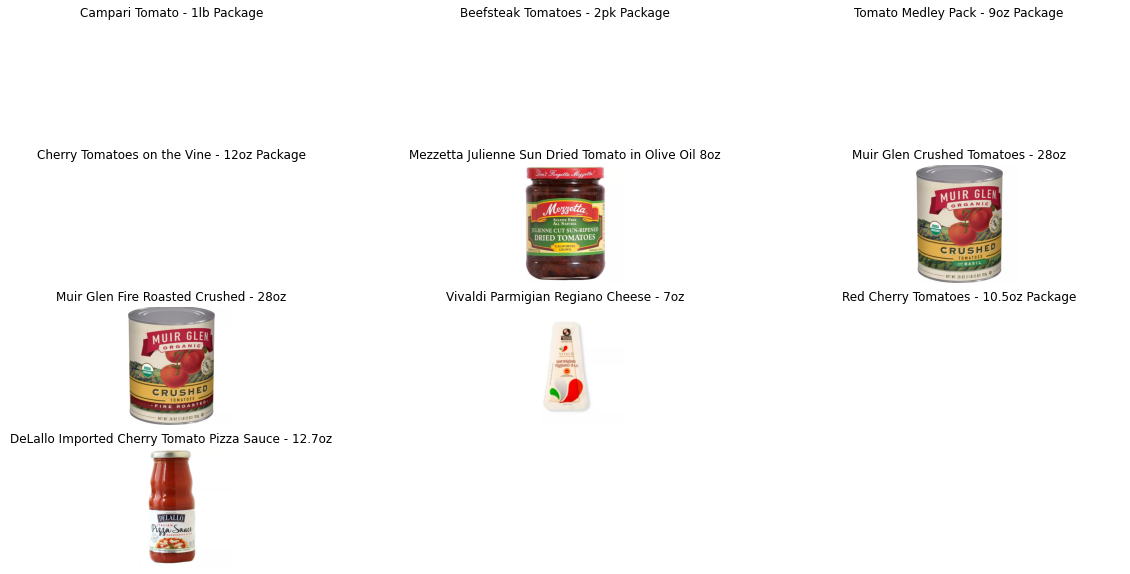

In [302]:
dp.display_products_ingredient_tcins(tcins)

In [298]:
def counts_per_doc(docs):
    counts = {}
    for i in range(len(docs)):
        words = set([str(x) for x in docs[i]]) 
        for word in words:
            counts[word] = counts.get(word, 0) + 1
    return counts

In [804]:
counts = counts_per_doc(texts)

In [805]:
def compute_tfidf(counts, N):
    tfidf = {"UNK": np.log(N) }
    for w in counts:
        tfidf[w] = np.log(N/counts[w])
    return tfidf

In [806]:
N = len(texts)
N

23247

In [807]:
tfidf = compute_tfidf(counts, N)

In [808]:
def sentence_encoding_v2(s, tfidf=tfidf):
    v = np.array([x.vector*(tfidf.get(str(x), tfidf["UNK"])) for x in s])
    return v.mean(axis=0)

In [809]:
import spacy

In [810]:
nlp = spacy.load('en_core_web_sm')

In [811]:
def tokenize_sentence(s):
    s = nlp(str(s.strip()))
    return np.array([token for token in s])

In [812]:
x = [tokenize_sentence(" ".join(text)) for text in tqdm(texts)]

100%|██████████| 23247/23247 [10:31<00:00, 36.82it/s]   


In [823]:
def sentence_encoding_v2(s, tfidf=tfidf):
    v = np.array([x.vector*(tfidf.get(str(x), tfidf["UNK"])) for x in s])
    return v.mean(axis=0)

x_train = np.array([sentence_encoding_v2(x[i]) for i in range(len(x))])

In [814]:
def sentence_encoding(s):
    v = np.array([x.vector for x in s])
    return v.mean(axis=0)

In [815]:
x_train = np.array([sentence_encoding(x[i]) for i in range(len(x))])

In [829]:
ingredient = 'sugar'
noun = get_noun(ingredient)
hyponyms = get_hyponyms(ingredient)
hypernym = get_hypernym(ingredient)
synonyms = get_synonyms(ingredient)
multiple_nouns = get_noun_food(ingredient)
if len(multiple_nouns) and multiple_nouns != ingredient:
    query =  ingredient +  ' ' + multiple_nouns
query =  " ".join(hyponyms) + ' ' + " ".join(synonyms) + ' ' + ingredient + ' ' + hypernym + ' ' + multiple_nouns
query
tokenized_query = tokenizer(query)

In [830]:
tokenized_query

['beet',
 'sugar',
 'cane',
 'sugar',
 'granulated',
 'sugar',
 'sugar',
 'loaf',
 'corn',
 'sugar',
 'brown',
 'sugar',
 'caramelized',
 'sugar',
 'lump',
 'sugar',
 'sugarloaf',
 'loaf',
 'sugar',
 'caramel',
 'clams',
 'bread',
 'dough',
 'kale',
 'cabbage',
 'scratch',
 'refined',
 'sugar',
 'sugar',
 'lettuce',
 'lolly',
 'sugar',
 'sweetening',
 'sugar']

In [831]:
ing = tokenize_sentence(" ".join(tokenized_query))
ing_vector = sentence_encoding_v2(ing)
# ing_vector = sentence_encoding(ing)

In [832]:
ing_vector = ing_vector.reshape(1, -1)

In [833]:
from sentence_transformers import util

In [834]:
scores = util.pytorch_cos_sim(ing_vector, x_train)[0]

In [835]:
group10['scores'] = scores
group10.sort_values('scores', ascending=False)[['title', 'scores']].head(100).values

array([['Crystal Dark Brown Sugar - 2lbs', 0.9308555126190186],
       ['Koia Magic Mango Smoothie - 12 fl oz', 0.9146780967712402],
       ['Malfy Originale Gin - 750ml Bottle', 0.9141361117362976],
       ['Roth Cabernet Sauvignon Red Wine - 750ml Bottle',
        0.913996696472168],
       ['Sour Patch Kids Peg Bag - 4oz', 0.9132769107818604],
       ['Kit-Kat Ice Cream Cone - 8ct', 0.9123331308364868],
       ['Shipyard Export Ale Beer - 6pk/12 fl oz Bottles',
        0.9122854471206665],
       ['Louis Jadot Beaujolais Red Wine - 750ml Bottle',
        0.9108126759529114],
       ['Koia Vanilla Bean Plant Powered Nutrition Drink - 12 fl oz',
        0.9104215502738953],
       ['Alexander Valley Cabernet Sauvignon Red Wine - 750ml Bottle',
        0.9099678993225098],
       ['Koia Straw-nana Dream Smoothie - 12 fl oz', 0.9090055227279663],
       ["Seagram's Ginger Ale - 2 L Bottle", 0.90815269947052],
       ['The Federalist Bourbon Barrel Aged Cabernet Sauvignon Red Wine - 750m